In [41]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100

In [42]:
# create data
preprocess = transforms.Compose([
    transforms.Resize(84),
    transforms.CenterCrop(84),
    transforms.ToTensor()
])

train_dataset = CIFAR100("./data", transform=preprocess,
                          download=True, train=True)

val_dataset = CIFAR100("./data", transform=preprocess,
                        download=True, train=False)

train_loader = DataLoader(train_dataset,
                          batch_size=25, pin_memory=True,
                          num_workers=16, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
train_features, train_labels = next(iter(train_loader))

In [44]:
class PadPrompter(nn.Module):
    def __init__(self):
        super(PadPrompter, self).__init__()
        pad_size = 10
        image_size = 84

        self.base_size = image_size - pad_size*2
        self.pad_up = nn.Parameter(torch.randn([1, 3, pad_size, image_size]))
        self.pad_down = nn.Parameter(torch.randn([1, 3, pad_size, image_size]))
        self.pad_left = nn.Parameter(torch.randn([1, 3, image_size - pad_size*2, pad_size]))
        self.pad_right = nn.Parameter(torch.randn([1, 3, image_size - pad_size*2, pad_size]))

    def forward(self, x):
        
        print("x == ", x.shape)
        
        base = torch.zeros(1, 3, self.base_size, self.base_size)
        prompt = torch.cat([self.pad_left, base, self.pad_right], dim=3)
        prompt = torch.cat([self.pad_up, prompt, self.pad_down], dim=2)
        prompt = torch.cat(x.size(0) * [prompt])
        
        print("x.size(0) == ", x.size(0))

        return x + prompt

In [45]:
prompt = PadPrompter()

for key, value in prompt.named_parameters():
    print("key == ", key, "  parameter shape == ", value.shape)

key ==  pad_up   parameter shape ==  torch.Size([1, 3, 10, 84])
key ==  pad_down   parameter shape ==  torch.Size([1, 3, 10, 84])
key ==  pad_left   parameter shape ==  torch.Size([1, 3, 64, 10])
key ==  pad_right   parameter shape ==  torch.Size([1, 3, 64, 10])


Feature batch shape: torch.Size([25, 3, 84, 84])
Labels batch shape: torch.Size([25])


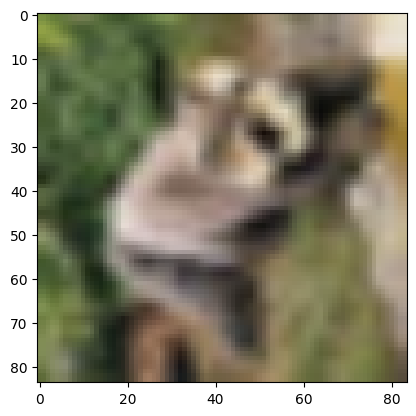

Label: 66


In [46]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].T
image = train_features[0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [47]:
prompted_images = prompt(train_features)

numpy_data = prompted_images[0].detach().numpy()

x ==  torch.Size([25, 3, 84, 84])
x.size(0) ==  25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


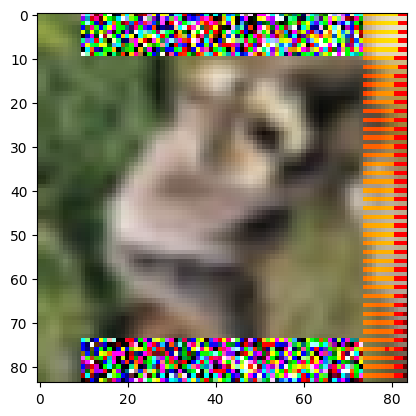

In [48]:
plt.imshow(numpy_data.T, cmap="gray")
plt.show()